## Importing the Libraries and Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline

In [358]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/CapstoneProject/train.csv")

## Exploratory Data Analysis

In [360]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [361]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [363]:
#question1 has 1 null value 
#question2 has 2 null values
#Let's locate which question1 has a null value
df[df.question1.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [364]:
#The Null question1 has an qid1 = 493340. 
#Let's check if there is an instance of qid = 493340 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 493340) | (df.qid2 == 493340)]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [366]:
#Let's check how many records are there where question2 is null
df[df.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [367]:
#The 2 instances of Null question2 have ids 174364. 
#Let's check if there is an instance of qid = 174364 is present anywhere in the dataset with a valid question attached to it.
df[(df.qid1 == 174364) | (df.qid2 == 174364)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [0]:
#We cannot fill this null question1 with the correct question. It is better to delete the record.

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

In [370]:
#Verifying the deletes
df[(df.question1.isnull()) | (df.question2.isnull())]

,id,qid1,qid2,question1,question2,is_duplicate


In [371]:
#Let's check if there are any records where question1 == question2
df[df.question1 == df.question2]

,id,qid1,qid2,question1,question2,is_duplicate


In [372]:
#Let's check if a qid1, qid2 pair is repeated more than once
pair_count = df.groupby(['qid1','qid2']).size()
pair_count[pair_count > 1]

Series([], dtype: int64)

In [373]:
#The above code will not capture the scenario if qid1 and qid2 are interchanged. 
#Let's see if there cases such as qid1=N1/qid2=N2 and qid1=N2/qid2=N1.
list_of_qids_1_2 = (df['qid1'].astype(str) + '-' + df['qid2'].astype(str)).tolist() 
list_of_qids_2_1 = (df['qid2'].astype(str) + '-' + df['qid1'].astype(str)).tolist()
combined_list = pd.Series(list_of_qids_1_2 + list_of_qids_2_1)
result = combined_list.duplicated()
result[result == True]

Series([], dtype: bool)

In [374]:
#Let's check how many unique instances of qid1 are there.
len(df.qid1.unique())

290652

In [375]:
#Let's check how many unique instances of qid2 are there.
len(df.qid2.unique())

299362

In [0]:
#Based on the above queries, a question might be repeated in more than one pair.

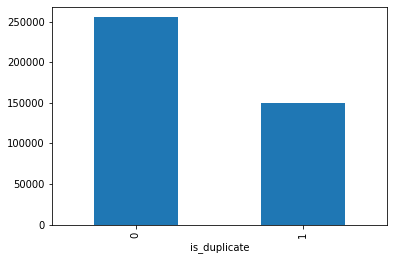

In [377]:
#Graph of duplicates vs non-duplicates
df.groupby("is_duplicate")['id'].count().plot.bar()

In [378]:
#Average number of words per question
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')
print('Mean question1 : ', df['question1'].str.split().apply(len).mean(), ' words')
print('Median question1 : ', df['question1'].str.split().apply(len).median(), ' words')

Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words
Mean question1 :  10.942256367382576  words
Median question1 :  10.0  words


In [379]:
print('Not Duplicate Question Pairs (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nDuplicate Question Pairs (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Not Duplicate Question Pairs (is_duplicate = 0):
   63.08%

Duplicate Question Pairs (is_duplicate = 1):
   36.92%


In [0]:
df_not_duplicate = df[df.is_duplicate == 0].sample(n = 5000)
df_duplicate = df[df.is_duplicate == 1].sample(n = 5000)
df = df_not_duplicate.append(df_duplicate)

In [381]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
314890,314890,439709,439710,What are some similar websites to ontwik.com?,What are the similar websites like Latestone.c...,0
26767,26767,49769,49770,What would you call someone that believes in G...,What do we call a religion which does not beli...,0
90052,90052,151179,151180,Why is 1 neither prime nor composite?,What are prime and composite numbers?,0
330838,330838,457637,457638,In my lab they have put 3 security cameras. So...,What is a way to gauge the quality of a movie ...,0
67018,67018,116059,80852,I caught my husband lying. He almost cheated o...,How do you cope with a lying cheating husband?,0


In [382]:
print('Not Duplicate Question Pairs (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nDuplicate Question Pairs (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Not Duplicate Question Pairs (is_duplicate = 0):
   50.0%

Duplicate Question Pairs (is_duplicate = 1):
   50.0%


## Processing Text Data

In [0]:
#Deleting records with null in qid1 or qid2
df = df.dropna(subset=['question1','question2'])

In [384]:
#Convert question1 and question2 to lower case
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
314890,314890,439709,439710,what are some similar websites to ontwik.com?,what are the similar websites like latestone.c...,0
26767,26767,49769,49770,what would you call someone that believes in g...,what do we call a religion which does not beli...,0
90052,90052,151179,151180,why is 1 neither prime nor composite?,what are prime and composite numbers?,0
330838,330838,457637,457638,in my lab they have put 3 security cameras. so...,what is a way to gauge the quality of a movie ...,0
67018,67018,116059,80852,i caught my husband lying. he almost cheated o...,how do you cope with a lying cheating husband?,0


In [385]:
#Remove punctuation
df['question1'] = df['question1'].str.replace(r'[^\w\s]+', '')
df['question2'] = df['question2'].str.replace(r'[^\w\s]+', '')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
314890,314890,439709,439710,what are some similar websites to ontwikcom,what are the similar websites like latestoneco...,0
26767,26767,49769,49770,what would you call someone that believes in g...,what do we call a religion which does not beli...,0
90052,90052,151179,151180,why is 1 neither prime nor composite,what are prime and composite numbers,0
330838,330838,457637,457638,in my lab they have put 3 security cameras so ...,what is a way to gauge the quality of a movie ...,0
67018,67018,116059,80852,i caught my husband lying he almost cheated on...,how do you cope with a lying cheating husband,0


In [0]:
#Word Replacements
def word_replace(x):
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                            .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                            .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                            .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                            .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                            .replace("€", " euro ").replace("'ll", " will")
  return x

df["question1"] = df["question1"].fillna("").apply(word_replace)
df["question2"] = df["question2"].fillna("").apply(word_replace)

In [387]:
#Lemmatization
df['question1'] = df['question1'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
df['question2'] = df['question2'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
314890,314890,439709,439710,what are some similar website to ontwikcom,what are the similar website like latestonecom...,0
26767,26767,49769,49770,what would you call someone that belief in god...,what do we call a religion which doe not belie...,0
90052,90052,151179,151180,why is 1 neither prime nor composite,what are prime and composite number,0
330838,330838,457637,457638,in my lab they have put 3 security camera so t...,what is a way to gauge the quality of a movie ...,0
67018,67018,116059,80852,i caught my husband lying he almost cheated on...,how do you cope with a lying cheating husband,0


## Feature Extraction

In [0]:
#Words difference q1, q2
df['words_diff_q1_q2'] = abs(df['question1'].apply(lambda row: len(row.split(" "))) - df['question2'].apply(lambda row: len(row.split(" "))))

In [0]:
#Number of common unique words in Question 1 and Question 2
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
    
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

In [0]:
#Total num of words in Question 1 + Total num of words in Question 2
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
df['word_Total'] = df.apply(normalized_word_Total, axis=1)    

In [0]:
#word_share = (word_common)/(word_Total)
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [0]:
#Distance computations
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

def convert(lst): 
    return (lst[0].split())

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

q1_q2_vectors = {}

def get_q1_q2_vectors(row):

      if row['id'] not in q1_q2_vectors:
          
          vocab = set()
          
          q1_list = []
          # print(type(q1_list))
          q1_list.append(row['question1'].replace("\n", " "))          
          vocab = vocab.union(set(convert(q1_list)))

          q2_list = []
          q2_list.append(row['question2'].replace("\n", " "))
          vocab = vocab.union(set(convert(q2_list)))          

          # integer encode sequences of words
          tokenizer = Tokenizer(filters=[])
          tokenizer.fit_on_texts(vocab)

          q1_seq = tokenizer.texts_to_sequences(q1_list)
          q2_seq = tokenizer.texts_to_sequences(q2_list)

          PAD_LENGTH = len(q1_seq[0]) + len(q2_seq[0])
          q1_seq_padded = pad_sequences(q1_seq, maxlen=PAD_LENGTH)
          q2_seq_padded = pad_sequences(q2_seq, maxlen=PAD_LENGTH)

          q1_seq_sorted = np.sort(q1_seq_padded[0])
          q2_seq_sorted = np.sort(q2_seq_padded[0])

          q1_q2_list = []
          q1_q2_list.append(q1_seq_sorted)
          q1_q2_list.append(q2_seq_sorted)

          q1_q2_vectors[row['id']] = q1_q2_list

      return q1_q2_vectors[row['id']][0], q1_q2_vectors[row['id']][1]

def get_cosine_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return cosine(q1_q2_vectors[0], q1_q2_vectors[1])

def get_cityblock_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return cityblock(q1_q2_vectors[0], q1_q2_vectors[1])

def get_jaccard_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return jaccard(q1_q2_vectors[0], q1_q2_vectors[1])

def get_canberra_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return canberra(q1_q2_vectors[0], q1_q2_vectors[1])

def get_euclidean_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return euclidean(q1_q2_vectors[0], q1_q2_vectors[1])

def get_minkowski_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return minkowski(q1_q2_vectors[0], q1_q2_vectors[1])

def get_braycurtis_distance(row):
  q1_q2_vectors = get_q1_q2_vectors(row)
  return braycurtis(q1_q2_vectors[0], q1_q2_vectors[1])  

df['cosine_distance'] = df.apply(get_cosine_distance, axis=1)  
df['cityblock_distance'] = df.apply(get_cityblock_distance, axis=1)
df['jaccard_distance'] = df.apply(get_jaccard_distance, axis=1)
df['canberra_distance'] = df.apply(get_canberra_distance, axis=1)
df['euclidean_distance'] = df.apply(get_euclidean_distance, axis=1)
df['minkowski_distance'] = df.apply(get_minkowski_distance, axis=1)
df['braycurtis_distance'] = df.apply(get_braycurtis_distance, axis=1)

# Vectorizing using TfidfVectorizer
q1_q1_vectors = {}

from sklearn.feature_extraction.text import TfidfVectorizer
def get_q1_q1_vectors_old(row):

      if row['id'] not in q1_q1_vectors:
          
          tfidf_matrix_list =[]

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          documents.append(row['question2'].replace("\n", " "))
          tfidf_vectorizer = TfidfVectorizer(max_features = 200)
          tfidf_vectorizer.fit(documents) 

          documents = []
          documents.append(row['question1'].replace("\n", " "))
          tfidf_matrix_q1 = tfidf_vectorizer.transform(documents)  
          tfidf_matrix_list.append(tfidf_matrix_q1)

          documents = []
          documents.append(row['question2'].replace("\n", " "))
          tfidf_matrix_q2 = tfidf_vectorizer.transform(documents) 
          tfidf_matrix_list.append(tfidf_matrix_q2)

          q1_q1_vectors[row['id']] = tfidf_matrix_list

      return q1_q1_vectors[row['id']][0], q1_q1_vectors[row['id']][1]


In [393]:
df[df.is_duplicate == 0].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
314890,314890,439709,439710,what are some similar website to ontwikcom,what are the similar website like latestonecom...,0,1,4.0,15.0,0.266667,0.039123,16,0.875000,2.818033,6.480741,6.480741,0.186047
26767,26767,49769,49770,what would you call someone that belief in god...,what do we call a religion which doe not belie...,0,13,9.0,37.0,0.243243,0.135437,226,1.000000,17.444874,49.132474,49.132474,0.410909
90052,90052,151179,151180,why is 1 neither prime nor composite,what are prime and composite number,0,1,2.0,13.0,0.153846,0.014182,8,0.857143,1.778211,3.464102,3.464102,0.108108
330838,330838,457637,457638,in my lab they have put 3 security camera so t...,what is a way to gauge the quality of a movie ...,0,20,4.0,35.0,0.114286,0.225789,335,0.968750,23.693379,70.618694,70.618694,0.448461
67018,67018,116059,80852,i caught my husband lying he almost cheated on...,how do you cope with a lying cheating husband,0,14,4.0,31.0,0.129032,0.207201,209,0.956522,16.863405,50.783856,50.783856,0.457330


In [0]:
# FuzzyWuzzy is a library of Python which is used for string matching. 
# Fuzzy string matching is the process of finding strings that match a given pattern. 
# Basically it uses Levenshtein Distance to calculate the differences between sequences.

# !pip install fuzzywuzzy
# !pip install python-Levenshtein
from fuzzywuzzy import fuzz

df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [395]:
# Generating N-grams
# Generate bigrams for every q1 and q2 and count the common bigrams.
# Generate trigrams for every q1 and q2 and count the common trigrams.

import nltk
nltk.download('punkt')
# nltk.download('wordnet')
from textblob import TextBlob, Word

def get_common_bigrams_count(row):
  q1_bigrams = TextBlob(row['question1'].replace("\n", " ")).ngrams(2)
  q2_bigrams = TextBlob(row['question2'].replace("\n", " ")).ngrams(2)

  common=[]
  for bigrams in q1_bigrams:
      if bigrams in q2_bigrams:
        common.append(bigrams)

  return len(common)

def get_common_trigrams_count(row):
  q1_trigrams = TextBlob(row['question1'].replace("\n", " ")).ngrams(3)
  q2_trigrams = TextBlob(row['question2'].replace("\n", " ")).ngrams(3)

  common=[]
  for trigrams in q1_trigrams:
      if trigrams in q2_trigrams:
        common.append(trigrams)

  return len(common)

df['common_bigrams'] = df.apply(get_common_bigrams_count, axis=1)
df['common_trigrams'] = df.apply(get_common_trigrams_count, axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [396]:
df[df.is_duplicate == 1].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,common_bigrams,common_trigrams
5486,5486,10792,10793,which one is better nikon d5500 or canon 70d,which is a better dslr canon eos70d or nikon d...,1,1,7.0,19.0,0.368421,0.005748,11,0.800000,1.911586,4.123106,4.123106,0.089431,64,86,64,100,73,90,79,1,0
300230,300230,423006,262168,why cant i see all answer for a question on qu...,why cant i see my answer on quora anymore,1,3,8.0,21.0,0.380952,0.024495,28,1.000000,5.128566,8.366600,8.366600,0.208955,80,91,71,100,71,96,80,5,3
295278,295278,417293,417294,how close is vatgrown meat to commercialization,how close are we to switching from animal meat...,1,7,4.0,19.0,0.210526,0.112583,47,1.000000,8.337626,14.456832,14.456832,0.281437,54,55,55,100,57,58,51,2,0
338095,338095,32623,183643,doe money ha more importance in life,how important is money in life,1,1,3.0,13.0,0.230769,0.007523,7,1.000000,1.755478,2.645751,2.645751,0.098592,61,72,67,100,80,76,73,1,0
25604,25604,47704,47705,how is the mass of a neutron determined,what is the mass of a neutron how is this mass...,1,4,8.0,18.0,0.444444,0.055504,24,0.916667,5.990891,7.874008,7.874008,0.230769,77,95,74,100,79,100,81,6,4


In [0]:
# Save the dataframe as a pickle file
import pickle
df.to_pickle("drive/My Drive/Colab Notebooks/CapstoneProject/df_quora_10000_feat.pkl")

## Model Building and Predicting





In [0]:
# Open the pickle file and save it as dataframe
import pickle
df = pd.read_pickle("drive/My Drive/Colab Notebooks/CapstoneProject/df_quora_10000_feat.pkl")

In [399]:
X = df[['words_diff_q1_q2', 'word_Common',	'word_Total', 'word_share', 'cosine_distance','cityblock_distance',	'jaccard_distance','canberra_distance',	'euclidean_distance','minkowski_distance','braycurtis_distance', 'fuzz_qratio',	'fuzz_WRatio',	'fuzz_partial_ratio',	'fuzz_partial_token_set_ratio',	'fuzz_partial_token_sort_ratio',	'fuzz_token_set_ratio',	'fuzz_token_sort_ratio', 'common_bigrams',	'common_trigrams']]
y = df['is_duplicate']
X.head()

,words_diff_q1_q2,word_Common,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,common_bigrams,common_trigrams
314890,1,4.0,15.0,0.266667,0.039123,16,0.875000,2.818033,6.480741,6.480741,0.186047,69,69,71,100,71,73,67,2,0
26767,13,9.0,37.0,0.243243,0.135437,226,1.000000,17.444874,49.132474,49.132474,0.410909,48,86,55,100,55,76,54,0,0
90052,1,2.0,13.0,0.153846,0.014182,8,0.857143,1.778211,3.464102,3.464102,0.108108,62,65,63,100,66,68,65,0,0
330838,20,4.0,35.0,0.114286,0.225789,335,0.968750,23.693379,70.618694,70.618694,0.448461,39,86,52,100,50,50,41,2,0
67018,14,4.0,31.0,0.129032,0.207201,209,0.956522,16.863405,50.783856,50.783856,0.457330,37,86,49,100,64,64,46,0,0


In [0]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

#Splitting the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 99)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Transform the training data
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=X_test.columns)

# Transform the testing data
X_test = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test,columns=X_train.columns)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [0]:
#Defining the generic training pipeline
def train_model(classifier, X_train, y_train):

  #fit the training dataset on the classifier
  classifier.fit(X_train, y_train)  

  #predict the labels on validation dataset
  y_pred = classifier.predict(X_test)

  # for input, prediction, label in zip(X_test, y_pred, y_test):
  #   if prediction != label:
  #     print(input, 'has been classified as ', prediction, 'and should be ', label) 

  #create a variable that is the result of the model's prediction on the test data
  y_pred_prob = classifier.predict_proba(X_test)
  
  return y_pred, y_pred_prob

In [0]:
# defining a function that returns the model evaluation metrics
def get_model_evaluation_metrics(y_test, y_pred, y_pred_prob):  
  
  print(f'Accuracy Score : {metrics.accuracy_score(y_test, y_pred)}')
  print(f'\nClassification Report : \n{metrics.classification_report(y_test,y_pred)}')
  print(f'\nConfusion Matrix : \n{metrics.confusion_matrix(y_test,y_pred)}')

  # A Confusion Matrix is a way to summarize the classifier performance
  cm = metrics.confusion_matrix(y_test,y_pred)

  # True Negatives (TN), False Negatives (FN), False Positives (FP), True Positives (TP)
  TN = cm[0,0]
  FP = cm[0,1] # Also known as Type 1 error
  FN = cm[1,0] # Also known as Type 2 error
  TP = cm[1,1]

  # Sensitivity : refers to how often the prediction is correct when the actual value is positive (positive ==> question is duplicate).
  # We need our alogrithm to be less sensitive. That means, when in doubt, it is better for a question to be considered as non-duplicate,
  # rather than duplicate. i.e, it is better to lean towards False Negative than False Positive.
  sensitivity = TP / (TP + FN) # also called as recall

  # Specificity : refers to how often the prediction is correct when the actual value is negative (negative ==> question is not-duplcate)
  # Our algorithm needs to be more specific and less sensitive.
  specificity = TN / (TN + FP)

  # Precision : refers to how often we are correct when the value predicted is positive
  precision = TP / (TP + FP)

  # False Positive Rate (FPR) : refers to how often we are incorrect when the actual value is negative. FPR = 1 - specicicity
  false_positive_rate = FP / (FP + TN)

  print(f'\nSensitivity (or recall) : {sensitivity:.2f}')
  print(f'Specificity : {specificity:.2f}')
  print(f'Precision : {precision:.2f}')
  print(f'False Positive Rate (FPR) : {false_positive_rate:.2f}')

  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

  plt.plot(fpr, tpr)
  plt.title("ROC Curve for Quora Question Duplicates")
  plt.xlabel("False Positive Rate (1 - Specificity)")
  plt.ylabel("True Positive Rate (Sensitivity)")
  plt.grid(True)
  plt.show()

  from sklearn.metrics import roc_auc_score

  print(f'\nAUC Score : {roc_auc_score(y_test, y_pred_prob[:,1])}')

## **Logistic Regression**

Accuracy Score : 0.6928

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1246
           1       0.67      0.78      0.72      1254

    accuracy                           0.69      2500
   macro avg       0.70      0.69      0.69      2500
weighted avg       0.70      0.69      0.69      2500


Confusion Matrix : 
[[758 488]
 [280 974]]

Sensitivity (or recall) : 0.78
Specificity : 0.61
Precision : 0.67
False Positive Rate (FPR) : 0.39


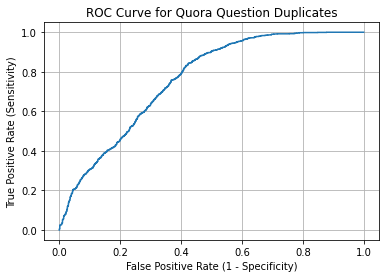


AUC Score : 0.7592071342810551


In [403]:
y_pred, y_pred_prob = train_model(linear_model.LogisticRegression(random_state = 99, max_iter=200), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Logistic Regression with L1 Regularization**

Accuracy Score : 0.6936

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1246
           1       0.67      0.78      0.72      1254

    accuracy                           0.69      2500
   macro avg       0.70      0.69      0.69      2500
weighted avg       0.70      0.69      0.69      2500


Confusion Matrix : 
[[757 489]
 [277 977]]

Sensitivity (or recall) : 0.78
Specificity : 0.61
Precision : 0.67
False Positive Rate (FPR) : 0.39


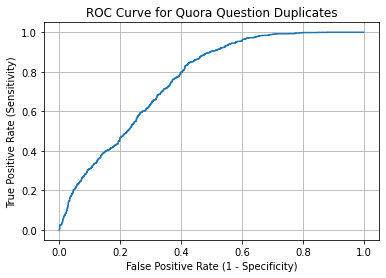


AUC Score : 0.7598490608543832


In [404]:
Cs = np.logspace(-2, 6, 9)
y_pred, y_pred_prob = train_model(linear_model.LogisticRegressionCV(Cs=Cs, penalty='l1', cv=10, solver='liblinear', random_state=99, max_iter=10000), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Logistic Regression with L2 Regularization**

Accuracy Score : 0.6932

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1246
           1       0.67      0.78      0.72      1254

    accuracy                           0.69      2500
   macro avg       0.70      0.69      0.69      2500
weighted avg       0.70      0.69      0.69      2500


Confusion Matrix : 
[[759 487]
 [280 974]]

Sensitivity (or recall) : 0.78
Specificity : 0.61
Precision : 0.67
False Positive Rate (FPR) : 0.39


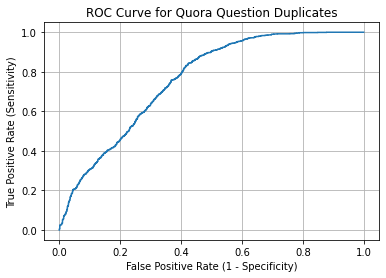


AUC Score : 0.759209054300716


In [405]:
Cs = np.logspace(-2, 6, 9)
y_pred, y_pred_prob = train_model(linear_model.LogisticRegressionCV(Cs=Cs, penalty='l2', cv=10, random_state=99, max_iter=10000), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Naive Bayes**

Accuracy Score : 0.6656

Classification Report : 
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1246
           1       0.67      0.66      0.66      1254

    accuracy                           0.67      2500
   macro avg       0.67      0.67      0.67      2500
weighted avg       0.67      0.67      0.67      2500


Confusion Matrix : 
[[841 405]
 [431 823]]

Sensitivity (or recall) : 0.66
Specificity : 0.67
Precision : 0.67
False Positive Rate (FPR) : 0.33


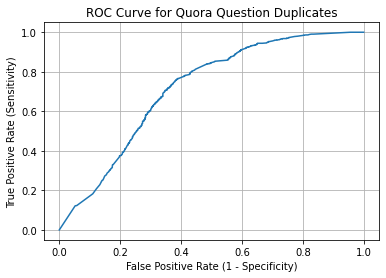


AUC Score : 0.7138559498849267


In [406]:
y_pred, y_pred_prob = train_model(naive_bayes.BernoulliNB(), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **SVM Classification**

Accuracy Score : 0.7028

Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1246
           1       0.66      0.82      0.74      1254

    accuracy                           0.70      2500
   macro avg       0.72      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500


Confusion Matrix : 
[[ 725  521]
 [ 222 1032]]

Sensitivity (or recall) : 0.82
Specificity : 0.58
Precision : 0.66
False Positive Rate (FPR) : 0.42


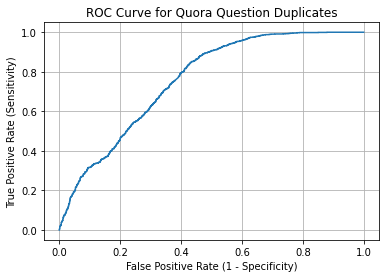


AUC Score : 0.7575949577723676


In [407]:
y_pred, y_pred_prob = train_model(svm.SVC(kernel='linear',random_state = 99, probability=True), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Decision-Tree Classification**

Accuracy Score : 0.6468

Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1246
           1       0.65      0.66      0.65      1254

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500


Confusion Matrix : 
[[795 451]
 [432 822]]

Sensitivity (or recall) : 0.66
Specificity : 0.64
Precision : 0.65
False Positive Rate (FPR) : 0.36


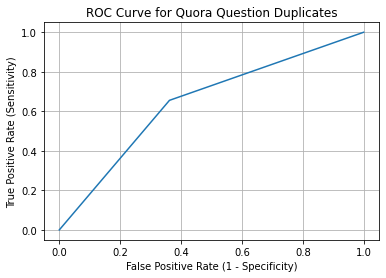


AUC Score : 0.6467720629459245


In [408]:
y_pred, y_pred_prob = train_model(tree.DecisionTreeClassifier(random_state = 99), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Random-Forest Classification**


Accuracy Score : 0.7108

Classification Report : 
              precision    recall  f1-score   support

           0       0.75      0.63      0.68      1246
           1       0.68      0.79      0.73      1254

    accuracy                           0.71      2500
   macro avg       0.72      0.71      0.71      2500
weighted avg       0.72      0.71      0.71      2500


Confusion Matrix : 
[[784 462]
 [261 993]]

Sensitivity (or recall) : 0.79
Specificity : 0.63
Precision : 0.68
False Positive Rate (FPR) : 0.37


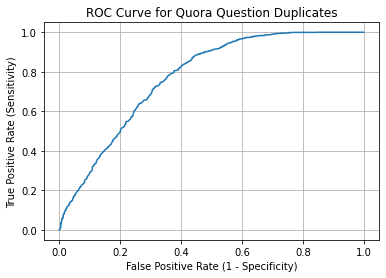


AUC Score : 0.7719528647973355


In [409]:
y_pred, y_pred_prob = train_model(ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state = 99), X_train, y_train)

get_model_evaluation_metrics(y_test, y_pred, y_pred_prob)

## **Deep Neural Network Models**

In [0]:
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import numpy as np
from tensorflow import random

from keras.layers import Dense

# Define 3 functions, each returning a different Keras model. 
# The goal is to find out which of these 3 models leads to the lowest cross-validation error rate.

# Create a function that returns the keras model 1
def build_model_1(activation='relu', optimizer='adam'):
  # create model 1  
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(18, activation=activation))
  model.add(Dense(18, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 1
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

# Create a function that returns the keras model 2
def build_model_2(activation='relu', optimizer='adam'):
  # create model 2
  # print(f'Activation = {activation}  Optimizer={optimizer}')
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(9, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 2
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

# Create a function that returns the keras model 3
def build_model_3(activation='relu', optimizer='adam'):
  # create model 3
  model = Sequential()
  model.add(Dense(18, input_dim=X_train.shape[1], activation=activation))
  model.add(Dense(9, activation=activation))
  model.add(Dense(6, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model
  



In [412]:
# Writing code that will loop over the three models and perform 5-fold cross-validation.
# define a seed for random number generator so the result will be reproducible
seed = 99
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation, number of epochs and batch size
n_folds = 5
batch_size = 20
epochs = 100

# define the list to store cross-validation scores
results_1 = []

# define the possible options for the model
models =[build_model_1, build_model_2, build_model_3]

# loop over the models
for m in range(len(models)):
  # build the scikit-learn interface for the keras model
  classifier = KerasClassifier(build_fn=models[m], epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
  # define the cross-validation iterator
  kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
  # perform the k-fold cross-validation and store the scores in result
  result = cross_val_score(classifier, X_train, y_train, cv=kfold)
  # add the scores to the results list
  results_1.append(result)

# Print cross-validation score for each model
for m in range(len(models)):
  print("Model ", m+1, " cross-validation score = ", abs(results_1[m].mean()))


Model  1  test error rate =  0.7054666757583619
Model  2  test error rate =  0.7171999931335449
Model  3  test error rate =  0.7130666494369506


In [415]:
# Choose the model with the highest cross-validation score and repeat the above step by iterating over the epochs = [100, 200] 
# and batches = [10, 20] values and performing 5-fold cross-validation

# define a seed for random number generator so the result will be reproducible
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation
n_folds = 5

# define the ossible options for epochs and batch_size
epochs = [100, 200]
batches = [10, 20]

# define the list to store cross-validation scores
results_2 = []

# loop over all possible pairs of epochs, batch_size
for e in range(len(epochs)):
  for b in range(len(batches)):
    # build the scikit-learn interface for the keras model
    classifier = KerasClassifier(build_fn=build_model_2, epochs=epochs[e], batch_size=batches[b], verbose=0)

    # define the corss-validation iterator
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # perform the k-fold cross-validation and store the scores in result
    result = cross_val_score(classifier, X_train, y_train, cv=kfold)

    # add the scores to the results list
    results_2.append(result)

# Print cross-validation score for each possible pair of epochs, batch_size
c = 0
for e in range(len(epochs)):
  for b in range(len(batches)):
    print("batch_size =", batches[b],", epochs =", epochs[e], ", Test Accuracy =", results_2[c].mean())
    c += 1

batch_size = 10 , epochs = 100 , Test Accuracy = 0.7166666746139526
batch_size = 20 , epochs = 100 , Test Accuracy = 0.719866669178009
batch_size = 10 , epochs = 200 , Test Accuracy = 0.7053333282470703
batch_size = 20 , epochs = 200 , Test Accuracy = 0.7058666825294495


In [436]:
# Choosing the batch size and epochs with the highest accuracy score and repeat the above step by iterating
# over the optimizers = ['rmsprop', 'adam', 'sgd'] and activations = ['relu','tanh'] values and 
# performing 5-fold corss validation

# define a seed for random number generator so the result will be reproducible
np.random.seed(seed)
random.set_seed(seed)

# determine the number of folds for k-fold cross-validation, number of epochs and batch size
n_folds = 5
batch_size = 10
epochs = 100

# define the list to store cross_validation scores
results_3 = []

# define possible options for optimizer and activation
optimizers = ['rmsprop', 'adam', 'sgd']
activations = ['relu','tanh']

# loop over all possible pairs of optimizer, activation
for o in range(len(optimizers)):
  for a in range(len(activations)):
    optimizer = optimizers[o]
    activation = activations[a]

    # build the scikit-learn interface for the keras model
    classifier = KerasClassifier(build_fn=build_model_2, activation=activation, optimizer=optimizer, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

    # define the cross-validation iterator
    kfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=seed)

    # perform the k-fold cross-validation and store the scores in result
    result = cross_val_score(classifier, X_train, y_train, cv=kfold)

    # add the scores to the results list
    results_3.append(result)

# Print cross-validation score for each possible pair of optimizer, activation
c = 0
for o in range(len(optimizers)):
  for a in range(len(activations)):
    print("activation = ", activations[a],", optimizer = ", optimizers[o], ", Test accuracy = ", results_3[c].mean())
    c += 1

activation =  relu , optimizer =  rmsprop , Test accuracy =  0.7082666635513306
activation =  tanh , optimizer =  rmsprop , Test accuracy =  0.7134666562080383
activation =  relu , optimizer =  adam , Test accuracy =  0.7087999939918518
activation =  tanh , optimizer =  adam , Test accuracy =  0.7069333314895629
activation =  relu , optimizer =  sgd , Test accuracy =  0.7204000115394592
activation =  tanh , optimizer =  sgd , Test accuracy =  0.7201333403587341


## **Improving the Model Accuracy (L1, L2 and Dropout Regularization)**



In [0]:
# So Model 2 with batch_size = 10 , epochs = 100, activation =  relu , optimizer =  sgd is the best model
# Now let's see how the model behaves with regularization
# write a function that returns the model 2 with the best hyperparameter values and takes l2 parameter as input 
# we will test it for different valies of l2 parameter

from keras.regularizers import l1, l2, l1_l2

def build_model_2_l1l2(kernel_regularizer=None): 
  model_2 = Sequential()
  model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=kernel_regularizer))
  model_2.add(Dense(9, activation='relu', kernel_regularizer=kernel_regularizer))
  model_2.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

  # fit the model to the training data to perform the classification while evaluating on the test set, 
  # saving the results of the training process
  history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

  # Plotting the trends in training error and test error by importing the necessary libraries for plotting the loss and
  # validation loss and saving them in the variable that was created when the model was fit to the training process. 
  # Printing out the maximum validation accuracy

 

  # plot training error and test error
  matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim(0,1)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'], loc='upper right')

  # print the best accuracy reached on the test set
  print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
  print("Lowest error on Training Set =", min(history.history['loss']))
  print("Lowest error on Validation Set =", min(history.history['val_loss']))


Best Accuracy on Validation Set = 0.7156000137329102
Lowest error on Training Set = 0.519805864572525
Lowest error on Validation Set = 0.5385132467746735


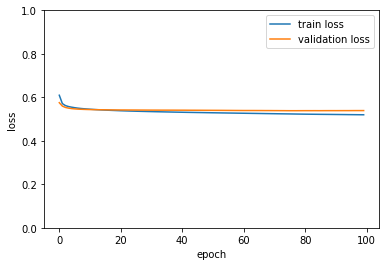

In [465]:
# Training the model with no regularization
build_model_2_l1l2(kernel_regularizer=None)

## **L2 Regularization**

Best Accuracy on Validation Set = 0.7167999744415283
Lowest error on Training Set = 0.5529270128409067
Lowest error on Validation Set = 0.5575796072483062


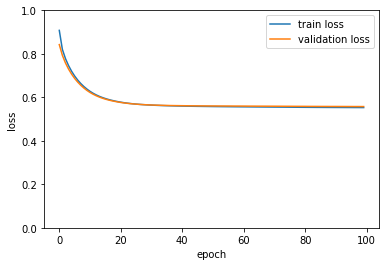

In [466]:
# Training the model by adding L2 regularizers with lambda=0.01 to each hidden layer of the model.
l2_param = 0.01
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

In [0]:
# As seen from the preceding plots, the test error almost plateaus after being decreased to a certain amount.
# The gap between the training error and the validation error at the end of the training process (the bias) is very
# small, which is indicative of reduced overfitting (low variance) of the model for the training examples. This is good.

Best Accuracy on Validation Set = 0.7008000016212463
Lowest error on Training Set = 0.5951399548053742
Lowest error on Validation Set = 0.5914834079742431


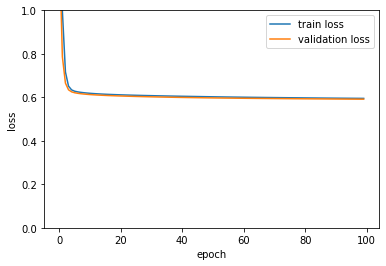

In [468]:
# Training the model by adding L2 regularizers with lambda=0.1 to each hidden layer of the model.
l2_param = 0.1
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

In [0]:
# The training and validation error quickly plateau and are much higher than they were for the model that was created
# with a lower L2 parameter, indicating that we have penalized the model so much that it has not had the flexibility to learn the
# underlying function of the training data. Following this, we will reduce the valie of the regularization parameter to prevent it
# from penalizing the model as much.

Best Accuracy on Validation Set = 0.7148000001907349
Lowest error on Training Set = 0.5471020164489746
Lowest error on Validation Set = 0.5537295563220977


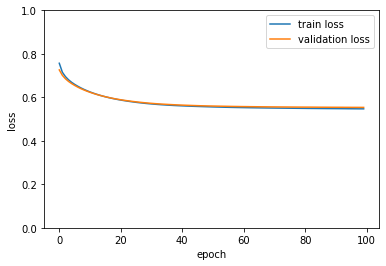

In [470]:
# Repeat the previous step with lambda=0.005 for the L2 parameter.
l2_param = 0.005
build_model_2_l1l2(kernel_regularizer=l2(l2_param))

In [0]:
# The value for the L2 weight regularization achieves the second highest accuracy that was evaluated on the validation data of all
# models with L2 regularization. Again, the test error doesn't increase
# a significant amount after being decreased to a certain value, which is indicative of the model not overfitting the training examples.
# It seems that L2 weight regularization with lambda=0.005 achieves the lowest validation error while preventing the model
# from overfitting.

## **L1 Regularization**

Best Accuracy on Validation Set = 0.7092000246047974
Lowest error on Training Set = 0.5822986573378245
Lowest error on Validation Set = 0.5782577345371246


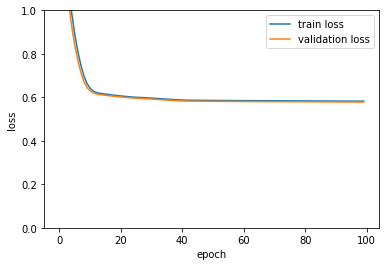

In [471]:
# Repeat the previous step with lambda=0.01 for the L1 parameter.
l1_param = 0.01
build_model_2_l1l2(kernel_regularizer=l1(l1_param))

Best Accuracy on Validation Set = 0.7099999785423279
Lowest error on Training Set = 0.5727731577555338
Lowest error on Validation Set = 0.5696559178829194


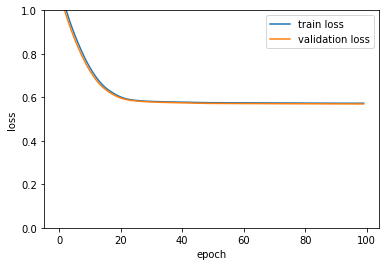

In [472]:
# Repeat the previous step with lambda=0.005 for the L1 parameter.
l1_param = 0.005
build_model_2_l1l2(kernel_regularizer=l1(l1_param))

In [0]:
# It seems that L1 weight regularization with lamda=0.005 achieves a better test error while preventing a model from 
# overfitting since the value of lambda=0.01 is too restrictive and prevents the model from learning the underlying
# function of the training data.

Best Accuracy on Validation Set = 0.7080000042915344
Lowest error on Training Set = 0.5760435692469279
Lowest error on Validation Set = 0.5718391695022583


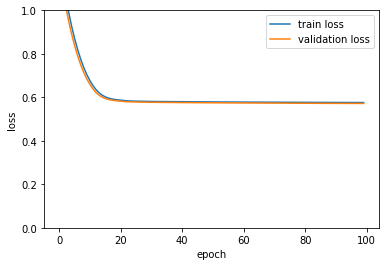

In [474]:
# Repeat the previous step with L1 and L2 regularizers with an L1 of lambda=0.005 and an L2 of lambda=0.005
# to the hidden layers of the model.
l1_param = 0.005
l2_param = 0.005
build_model_2_l1l2(kernel_regularizer=l1_l2(l1=l1_param, l2=l2_param))

In [0]:
# While L1 and L2 regularization are successful in preventing the model from overfitting, the variance in the model
# is very low. However, the accuracy that's obtained on the validaton set is not as high as the model that was
# trained with no regularization or the model that was trained with the 
# L2 regularization lambda=0.005 or L1 regularization lambda = 0.005 parameter individually.

## **Dropout Regularization**

Best Accuracy on Validation Set = 0.7120000123977661
Lowest error on Training Set = 0.5267147301038106
Lowest error on Validation Set = 0.5404192833900452


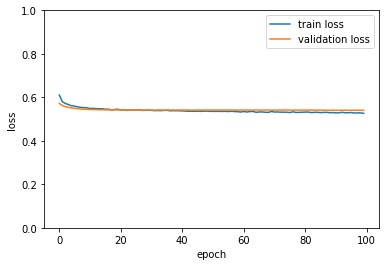

In [477]:
# Model 2 : batch_size = 10 , epochs = 100, activation =  relu , optimizer =  sgd 
# Now let's see how the model behaves with dropout regularization

# Redefine the model by creating the same model architecture
# Add a dropout regularization with rate = 0.1 to the first hidden layer of the model.
# Repeat the steps to train the model on the training data and to plot the trends for the training and validation errors.
# Then print the best accuracy that was reached on the validation set.

from keras.layers import Dropout

# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# There is a very small gap between the training error and the validation error. The validation error is slightly higher than
# the training error, indicating that the model is might be overfitting the training data.

Best Accuracy on Validation Set = 0.7080000042915344
Lowest error on Training Set = 0.5310429490407308
Lowest error on Validation Set = 0.5384255845546723


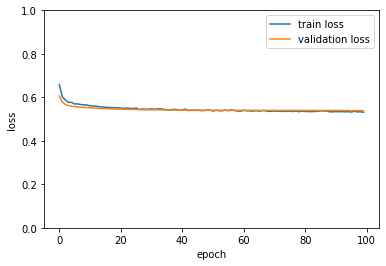

In [479]:
# Repeating the previous step, this time adding dropout regularization with rate=0.1 to all hidden layers of your model.
# Repeat the steps to train the model on the training data and plot the trends for the training and validation errors.

# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# The training error has increased as a result of additional regularization on the other 2 hidden layers of the model.

Best Accuracy on Validation Set = 0.7184000015258789
Lowest error on Training Set = 0.5359634370803833
Lowest error on Validation Set = 0.5398985111713409


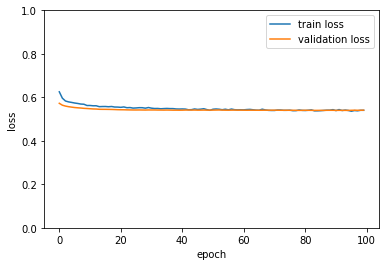

In [481]:
# Repeating the previous step, this time adding dropout regularization with rate=0.2 to the first layer and rate=0.1 to the rest of 
# the hidden layers
# Repeat the steps to train the model on the training data and plot the trends for the training and validation errors.

# create model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(1, activation='sigmoid'))
# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
# train the model using training set while evaluating on the test set
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

# print the best accuracy reached on the test set
print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# The gap between the training error and validation error is slightly larger due to the increase in regularization.
# In this case, there was no overfitting in the original model. 
# As a result, regularization increased the error rate on the training and validation dataset.

## **Early Stopping**<br/>
By monitoring the training process, we can train the model just enough for it to capture the form of the process, and we can stop the training right before it starts to overfit to individual data examples. This means forcing the Keras model to stop the training when a desired metric e.g. test error rate is not improving anymore.

Best Accuracy on Validation Set = 0.7160000205039978
Lowest error on Training Set = 0.5199723019599914
Lowest error on Validation Set = 0.5412468502521515


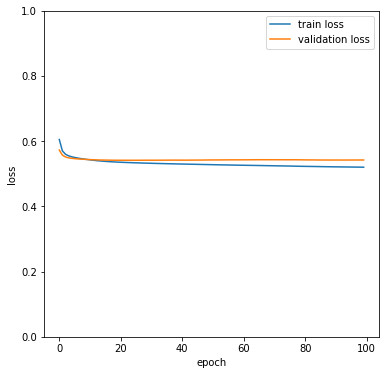

In [490]:
# Recreate the base model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# From the preceding plot, we can see that the training the model for 100 epochs results in a gap that
# grows between the training error and validation error, which is indicative of overfitting beginning to happen.

Best Accuracy on Validation Set = 0.7148000001907349
Lowest error on Training Set = 0.5297336949507395
Lowest error on Validation Set = 0.5417783272266388


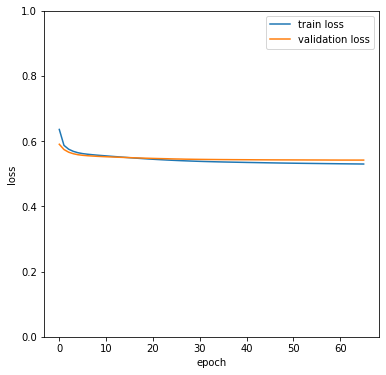

In [491]:
# Redefining the model exactly the same way and adding a callback to the training process

from keras.callbacks import EarlyStopping
# Recreate the base model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# define early stopping callback
# since the metric is error/loss, we would like to minimize it
es_callback = EarlyStopping(monitor='val_loss', mode='min')

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), callbacks=[es_callback], verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# By adding the early stopping callback with patience=0 to the model, the training process automatically stops 
# after about 65 epochs.
# If there are a lot of fluctuations or noise in the error rates, it is probably NOT a good idea to stop
# the training immediately when the loss begins to increase. For this reason, we can set the patience argument
# to a number  of epochs to give the early stopping method some time to monitor the desired metric for longer
# before stopping the training process.

Best Accuracy on Validation Set = 0.7160000205039978
Lowest error on Training Set = 0.5264881302515666
Lowest error on Validation Set = 0.5446123509407044


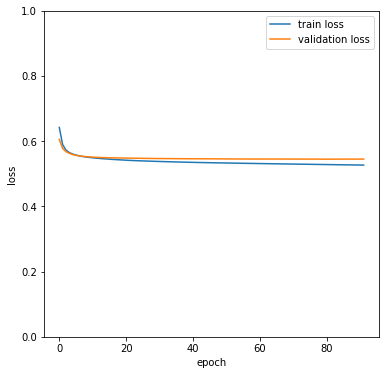

In [495]:
# Redefining the model and adding a callback with patience=10 to the training process

from keras.callbacks import EarlyStopping
# Recreate the base model
model_2 = Sequential()
model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dense(9, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# compile model 3
model_2.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

# define early stopping callback
# since the metric is error/loss, we would like to minimize it
es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

# train the model
history=model_2.fit(X_train, y_train, batch_size=20, epochs=100, validation_data=(X_test, y_test), callbacks=[es_callback], verbose=0, shuffle=False)

# plot training error and test error
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')

print("Best Accuracy on Validation Set =", max(history.history['val_accuracy']))
print("Lowest error on Training Set =", min(history.history['loss']))
print("Lowest error on Validation Set =", min(history.history['val_loss']))

In [0]:
# By adding the early stopping callback with patience=10 to the model, the training process automatically stops
# after about 85 epochs.

##**Hyperparameter Tuning with scikit-learn**<br/>
The process of training and evaluating models with different hyperparameters and deciding about the final hyperparameters based on model performance is called hyperparameter tuning or hyperparameter optimization.

In [0]:
# Recreate the function that returns the keras model with regularization
def build_model_2(lambda_parameter=lambda_parameter): 
  model_2 = Sequential()
  model_2.add(Dense(18, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(lambda_parameter)))
  model_2.add(Dense(9, activation='relu', kernel_regularizer=l2(lambda_parameter)))
  model_2.add(Dense(1, activation='sigmoid'))
  # compile model 3
  model_2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [0]:
# Set a seed, use a scikit-learn wrapper to wrap the model that we created in the previous step, and define
# the hyperparameters to scan. Finally, perform GridSearchCV() on the model using the hyperparameter's grid
# and fit the model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
# define a seed for random number generator so the result will be reproducible
seed = 99
np.random.seed(seed)
random.set_seed(seed)

# define all the possible values for each hyperparameter
lambda_parameter = [0.01, 0.5, 1]
epochs = [50, 100]
batch_size = [20]

# create the Keras wrapper with scikit learn
model = KerasClassifier(build_fn=build_model_2, verbose=0, shuffle=False)

print(model.loss)

# create the dictionary containing all possible values of hyperparameters
param_grid = dict(lambda_parameter=lambda_parameter, epochs=epochs, batch_size=batch_size)

# perform 5-fold cross-validation for the model and store the results
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

results_1 = grid_search.fit(X_train, y_train)

# Print the results for the best cross-valiation score that's stored within
# the variable that was created in the fit process. Iterate through all the parameters
# and print the mean of the accuracy across all the folds, the standard deviation
# of the accuracy and the parameters themselves.

print("Best cross-validation score =", results_1.best_score_)
print("Parameters for Best cross-validation score =", results_1.best_params_)

# print the results for all evaluated hyperparameter combinations
accuracy_means = results_1.cv_results_['mean_test_score']
accuracy_stds = results_1.cv_results_['std_test_score']
parameters = results_1.cv_results_['params']

for p in range(len(parameters)):
  print("Accuracy %f (std %f) for params %r" % (accuracy_means[p], accuracy_stds[p], parameters[p]))

